In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


LSTM ( long short term memory) is a RNN model.

At a macro level

It encapsulate the idea of 'how much weight' should be assigned to past (X t-n) information. In the same capacity, 'how much weight' should we forget on past information.
LSTM represent a more natural way of thinking. As humans we don't read a sentence in a single setting and assign weights to each word. We read and comprehend from left to right (in most cultures).

A word or phrase occuring at the beginning of a sentence may provide significant context to the meaning of a sentence. And LSTM captures that notion and allows it to carry through the entire sentence (memorize and assign significant weight to what was said at the begining of a sentence).

However in other cases words or phrases that also occur at the begining of a sentence may not provide any significant context, and thus no significant information will be retain via the LSTM cell.

Micro Level of a LSTM Cell

3 components of LSTM cell

1. forget gate
2. input gate
3. output gate


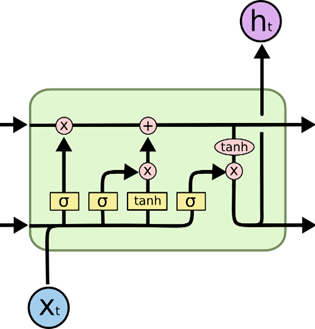

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### forget gate

- weight of the forget gate
- sum multiple by the previous cell (H t-1) and the input X t, get a scalar
- plus the bias
- Then after all that, input the scalar into the sigmoid function

if the output is 0 that means that no information is fed into the long term memory, which is represented by the first horizontal line going through the cell

if the output is 1 that means that all of the information is fed into the long term memory, probably something that capture important context and it is worth keeping and passing it on to t+1 for example.

the output can be between 0 and 1




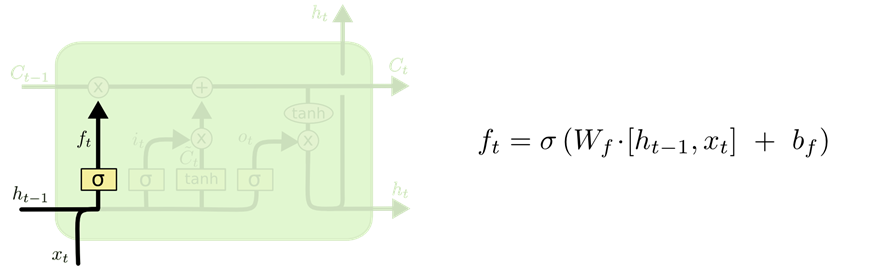

### input gate

- same as forget gate
- one additional tanh function added to the cell state at time = t
- what information will be output into long term memory is funtion of the previous output multiply by the forget gate value + the value of the current cell state x the sigmoid output
- the sigmoid can still be 0 in the input gate, which means that tanh cell is being passed through to long term memory

- my personal interpretation is the model is deciding the blend of the previous information + the current information


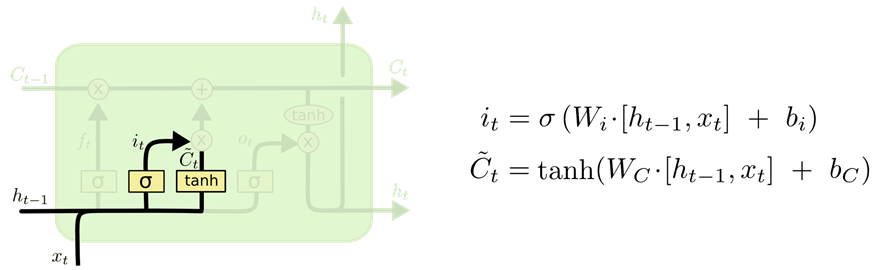

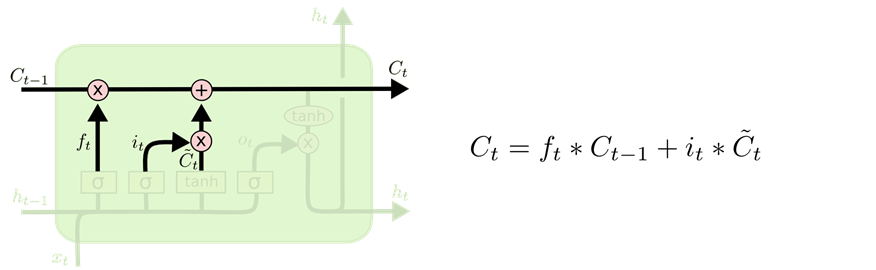

### output gate

finally, the output gate is deciding on how much informaiton to pass up ( long term memory) and how much to carry over to the short term memeory channel to the next H t


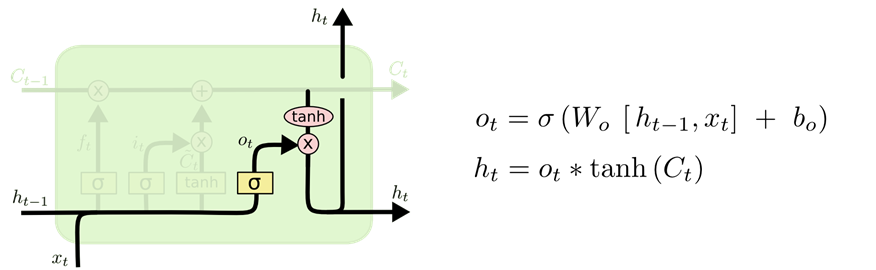

At a macro level 

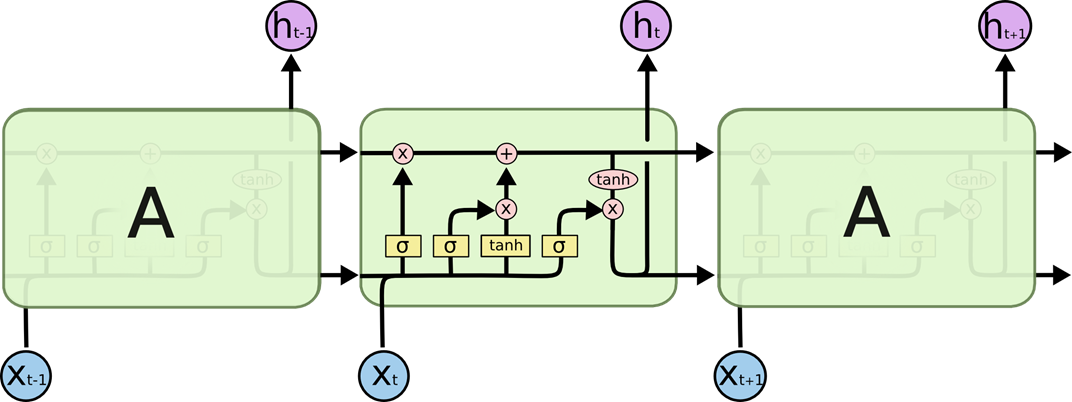

At even higher macro level

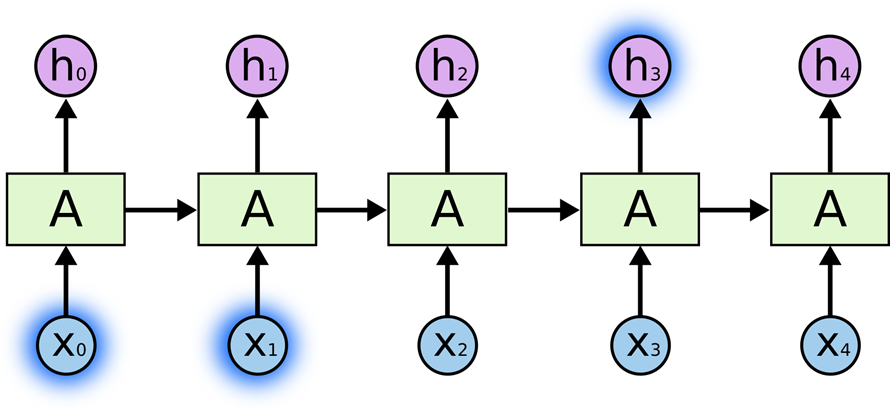

now that the mechanism of LSTM is understood. More complexed architechture can be comprehended more easyily, such as Bi directional LSTM, where the network backpropagates not only on forward looking, but also can backpropagate given future outcome

# Bi-Directional LSTM Keras

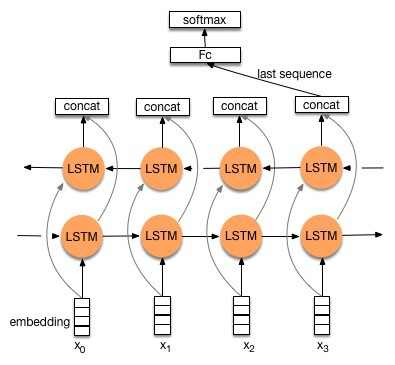

https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66

### let A= [come, hell, or, high, water]

### once tokenized let M= [1,2,3,4,5]

### it will feed M matrix into the LSTM cells, once finished the first forward feed layer it will reverse the matrix

### M_reversed= [5,4,3,2,1]

### [water, high, or, hell, come]

### Esssentially the bidirectional LSTM is updating it's graident based on the future outcome.

### then before proceeding into the output layer, the model will aggregate the two matrix. by default it's concatentation in Keras Bidreictional Wrapper. But you can specify

### - merge_mode: Mode by which outputs of the forward and backward RNNs will be combined. One of {'sum', 'mul', 'concat', 'ave', None}. If None, the outputs will not be combined, they will be returned as a list.

### concatentation

### M + M_reversed

### 1 X 10

### [1,2,3,4,5,5,4,3,2,1]

In [2]:
# I am using the same dataset as my other notebook Bigram_Keras_explain, I will also use the same seed for benchmarking

import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM, Bidirectional
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print(pd.__version__)



Using TensorFlow backend.


0.25.3


In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv", names=['comment', 'label'], header=0, encoding='utf-8')

In [4]:
# df=df1.sample(n=50000, random_state=23)
# Take a sample if necessary; for faster training

#check data format
print(df.iloc[0])

#check the labels in the dataset
df.label.value_counts()

#converts label into integer values
df['label'] = df.label.astype('category').cat.codes

comment    One of the other reviewers has mentioned that ...
label                                               positive
Name: 0, dtype: object


In [5]:
# counts the number of classes
# label the target feature

num_class = len(np.unique(df.label.values))
y = df['label'].values
print("\nThere are a total of " + str(num_class) + " classes.")

# evenly distributed dataset
df.groupby('label').count()


There are a total of 2 classes.


comment
label         
0        25000
1        25000

### We have to keep the matrix in the same sequential order as it was represented when us LSTM; order and sequencing matters. We cannot use feature selection for example in TfidfVectorizer

In [6]:
max_features = 22000 # number of words to be used in the word corpse
maxlen = 1600 #caught off point of the lenght of a sentence

tokenizer = Tokenizer()
#fits the comments on the comments
tokenizer.fit_on_texts(df.comment.values)
#changes the tokens into sequence data structures
post_seq= tokenizer.texts_to_sequences(df.comment.values)
post_seq_padded= pad_sequences(post_seq, maxlen=maxlen)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3, random_state=23)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers

model = Sequential()
model.add(Embedding(max_features, 100, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


# prints out summary of model
model.summary()

# saves the model weights
# the train/validation/test split is 26500/8750/15000, it's essential to hold out a decent chunck of unseen data
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=32, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=3, callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1600, 100)         2200000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,284,738
Trainable params: 2,284,738
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26250 samples, validate on 8750 samples
Epoch 1/3
26250/26250 [==============================] - 2706s 103ms/step - loss: 0.4198 - acc: 0.8040 - val_loss: 0.3889 - val_acc: 0.8299

Epoch 00001: val_acc improved from -inf to 0.82994, saving model to weights-simple.hdf5
Epoch 2/3
26250/26250 [==============================] - 2761s 105ms/step - loss: 0.2519 - acc: 0.9055 - val_loss: 0.2851 - val_acc: 0.8889

Epoch 00002: val_acc improved from 0.82994 to 0.88891, saving model to weights-simple.hdf5
Epoch 3/3
26250/26250 [==============================] - 2766s 105ms/step - loss: 0.2056 - acc: 0.9224 - val_loss: 0.4473 - val_acc: 0.7926

Epoch 00003: val_acc did not improve from 0.88891


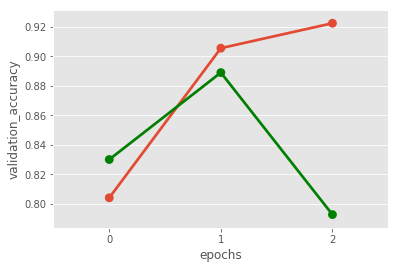

In [9]:
#plot model
df_result = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df_result, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df_result, fit_reg=False, color='green')



In [10]:
#get prediction accuarcy for testing dataset 15000 samples
predicted = model.predict(X_test)
predicted_best = np.argmax(predicted, axis=1)
print (accuracy_score(predicted_best, y_test))
predicted=pd.DataFrame(data=predicted)



0.7805333333333333


In [11]:
print (classification_report(predicted_best, y_test))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      8121
           1       0.74      0.80      0.77      6879

    accuracy                           0.78     15000
   macro avg       0.78      0.78      0.78     15000
weighted avg       0.78      0.78      0.78     15000



## Conclusion 

For this sentiment analysis task on IMDB dataset. The IDF unigram + bigram (https://www.kaggle.com/eriche523/bigram-keras-explained) still performs better and trains faster than Bidirectional LSTM. As expect Bidirectional LSTM specializes in NER task which is a much hard problem to tackle then sentiment analysis. 